<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculation-of-Null-Value" data-toc-modified-id="Calculation-of-Null-Value-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculation of Null Value</a></span></li><li><span><a href="#ESG-Data" data-toc-modified-id="ESG-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ESG Data</a></span></li><li><span><a href="#Out-of-sample-Results" data-toc-modified-id="Out-of-sample-Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Out of sample Results</a></span><ul class="toc-item"><li><span><a href="#Median-Comparison-between-EN-and-HAR" data-toc-modified-id="Median-Comparison-between-EN-and-HAR-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Median Comparison between EN and HAR</a></span></li><li><span><a href="#Comparison-Random-Forest" data-toc-modified-id="Comparison-Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Comparison Random Forest</a></span></li></ul></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Noise-3,-15,-and-30" data-toc-modified-id="Noise-3,-15,-and-30-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Noise 3, 15, and 30</a></span></li></ul></div>

In [231]:
from datetime import timedelta
from math import ceil
from numpy import asarray, log1p, expm1
from numpy import number
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sys
import time
import warnings
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

class DataProcessing():
    '''
    Class to train and infer stock price for one particular stock
    '''
    def __init__(self, mt_start, mt_end, 
                 daily = False, 
                 predict_days = 200,
                 index_path = '../data/1.1-FTSE-IDX_VOL30-PRICES_2006-2023.csv',
                #  price_path = '../data/1.1-FTSE_VOL30-PRICES_2006-2022.csv', # new threshold with 100 ftse only
                #  price_path = '../data/1.1-FTSE_VOL30-PRICES_2006-2023.csv',
                 price_path = '../data/1.1-FTSE_VOL21-PRICES_2006-2022.csv',
                 esg_path = '../data/1.2-FTSE_ESG_COR_2006-2023.csv'):

        self.mt_start = mt_start
        self.mt_end = mt_end
        self.predict_days = predict_days
        self.index_path = index_path
        self.price_path = price_path
        self.esg_path = esg_path
        self.daily = daily

    def count_train_test(self, train_df, test_df):
        master_df = pd.DataFrame()

        assets = train_df.Asset.unique().tolist()

        for _, asset in enumerate(assets): 
            df_train = train_df[train_df.Asset == asset].dropna()
            df_test = test_df[test_df.Asset == asset].dropna()

            master_df.loc[_ , 'Asset'] = asset
            master_df.loc[_ , 'Train Length'] = df_train.shape[0]
            master_df.loc[_ , 'Test Length'] = df_test.shape[0]
            master_df.loc[_ , 'Total Length'] = df_train.shape[0] + df_test.shape[0]

        return master_df
    
    def min_data_threshold(self, df):

        if self.daily:
            # At least 720 days or 2 years datapoints
            threshold = 360*2 

        else:
            # At least 24 months or 2 years datapoints.
            threshold = 24

        return df[df['Total Length'] >= threshold]['Asset'].tolist()
    
    def clean_first_valid_index(self, df):
        master_df = pd.DataFrame()

        for i, asset in enumerate(df.Asset.unique()):
            df_temp = df[df.Asset == asset]
            missing_numerical = [col for col in df_temp.columns if df_temp[col].isna().any()]

            # Loop over all columns
            for column in missing_numerical:
                # find the index of the first non-null observation in the column
                first_valid_index = df_temp[column].first_valid_index()

                # drop rows before the first non-null observation
                df_temp = df_temp.loc[first_valid_index:]

            master_df = pd.concat([master_df, df_temp])
            # print(f'clean first valid index done: {i} out of {len(df.Asset.unique())}')

        return master_df

    def clean_count_missing_rows_assets(self, df):
        master_df = pd.DataFrame()

        for i, asset in enumerate(df.Asset.unique()):
            df_temp = df[df.Asset == asset]
            df_clean = df_temp.dropna()
            
            temp2_df = pd.DataFrame({ 'num_assets': asset,
                            'missing_rows': df_temp.shape[0] - df_clean.shape[0],
                            'perc_missing': (df_temp.shape[0] - df_clean.shape[0]) / df_temp.shape[0],
                            'total_rows': df_temp.shape[0]
                        }, index= [i])
            
            master_df = pd.concat([master_df, temp2_df])

        return master_df
    
    def forward_fill_with_rolling_mean(self, s, window):
        for i in range(len(s)):
            if pd.isnull(s[i]):
                s[i] = s[:i].tail(window).mean()
        return s

    def clean_filna_assets_df(self, df):
        '''
        Version 1 of fill Null value, the first performance is using this function.
        '''

        Assets = df.Asset.unique()
        master_df = pd.DataFrame()
        print(len(Assets))

        for asset in Assets:
            temp_df = df[df['Asset'] == asset].reset_index(drop=True)

            # Select numerical columns
            numerical_columns = temp_df.select_dtypes(include=[number]).columns
            # Check for any missing values in these numerical columns
            missing_numerical = [col for col in numerical_columns if temp_df[col].isna().any()]
            
            for col in missing_numerical:
                # forward filling with rolling mean 30 days
                temp_df[col] = self.forward_fill_with_rolling_mean(temp_df[col], 30)
                

            temp_df = temp_df.reset_index(drop=True)
            master_df = pd.concat([master_df, temp_df])

        print(master_df.shape)
        return master_df

    def monthly_last_trading_date(self):

        date_list = []

        df = pd.read_csv(self.index_path)
        dt_trades = df.loc[:,['Date']]
        dt_trades.Date = pd.to_datetime(dt_trades.Date)
        dt_trades.loc[:, 'Month_Key'] = dt_trades.Date.apply(lambda x: x.strftime('%Y-%m-01'))
        dt_trades.Month_Key = pd.to_datetime(dt_trades.Month_Key)
        dt_trades = dt_trades[(dt_trades['Month_Key'] >= self.mt_start) & (dt_trades['Month_Key'] <= self.mt_end)]

        for date in dt_trades.Month_Key.unique():
            temp_df = dt_trades[dt_trades.Month_Key == date].copy()
            temp_df = temp_df.sort_values(by= 'Date', ascending=True)
            dt = temp_df.iloc[-1, 0]
            date_list.append(dt)

        self.date_list = date_list

    def data_preprocessing_price(self):

        select_cols = ['month_key', 'Date', 'Date (shifted)', 'Asset', 'Open', 'High', 'Low', 'Close', 'Return', 'V^CC', 'V^RS', 'V^YZ']
        
        price_df = pd.read_csv(self.price_path)
        price_df = price_df.rename(columns={'Month':'month_key'})
        price_df.Date = pd.to_datetime(price_df.Date)
        price_df.month_key = pd.to_datetime(price_df.month_key)
        price_df.Asset = price_df.Asset.astype(int)
        price_df = price_df[select_cols]
        price_df = price_df.dropna()

        if self.daily:
            # I change the days = 1 to days = 30 as per 31 July 2023.
            # price_df.loc[:, 'col_merge'] = price_df.Date.apply(lambda x: x - timedelta(days=30))
            price_df.loc[:, 'col_merge'] = price_df.Date
            price_df.col_merge = pd.to_datetime(price_df.col_merge)
            price_df.drop(['Date'], axis=1, inplace=True)
        else:
            price_df.loc[:, 'col_merge'] = price_df.month_key.apply(lambda x: x - timedelta(days=10))
            price_df.loc[:, 'col_merge'] = price_df.col_merge.apply(lambda x: x.strftime('%Y-%m-01'))
            price_df.col_merge = pd.to_datetime(price_df.col_merge)
            price_df = price_df[price_df.Date.isin(self.date_list)].reset_index(drop=True)

        self.price_df = price_df


    def data_preprocessing_esg(self):

        esg_df = pd.read_csv(self.esg_path)

        # set-up df
        esg_df.Asset = esg_df.Asset.astype(int)
        esg_df.Date = pd.to_datetime(esg_df.Date)
        esg_df = esg_df.drop(['windowTimestamp'], axis=1)

        if not self.daily:
            # set-up month_key column
            esg_df = esg_df[esg_df.Date.isin(self.date_list)].reset_index(drop=True)

        esg_df['month_key'] = esg_df.Date.apply(lambda x: x.strftime('%Y-%m-01'))
        esg_df.month_key = pd.to_datetime(esg_df.month_key)

        self.esg_df = esg_df

    def func_train_test_split(self):
        '''
        '''
        
        df = self.clean_df
        
        
        if self.daily:
            # lag_1, lag_2, lag_3 = 1*30, 3*30, 12*30
            lag_1, lag_2, lag_3 = 1, 5, 21
        else:
            # lag for monthly
            lag_1, lag_2, lag_3 = 1, 3, 12
        
        df['col_merge'] = pd.to_datetime(df['col_merge'])
        df['Date (shifted)'] = pd.to_datetime(df['Date (shifted)'])

        df.index = df['col_merge']

        train_df, test_df = pd.DataFrame(), pd.DataFrame()
        asset_lists = df.Asset.unique()

        for asset in asset_lists:
            # subset dataframe
            temp_df = df[df['Asset'] == asset].copy()
            temp_df.to_excel('test_csvcsv.xlsx')
            
            # temp_df.to_csv('test_sample.csv')
            # break
            # parameters
            predict_days = self.predict_days

            # setting up volatility lag to a dataframe
            vol_df = pd.DataFrame({
            'vol_series_daily' : temp_df['V^YZ'].shift(lag_1),
            'vol_series_weekly' : temp_df['V^YZ'].rolling(lag_2).mean().shift(1),
            'vol_series_monthly' : temp_df['V^YZ'].rolling(lag_3).mean().shift(1)
            })

            # additional feature
            vol_df = vol_df.shift(lag_3)

            pointer = temp_df.index[0] + timedelta(days = 30)
            target_vol = temp_df[temp_df.index >= pointer]

            temp_df = pd.merge(target_vol, vol_df, how = 'left', left_index=True, right_index=True).dropna()
            # display(temp_df)

            # split the subset into train_df
            train_df = pd.concat([temp_df.iloc[:-(predict_days)], train_df])
            test_df = pd.concat([temp_df.iloc[-(predict_days):], test_df])

        
        master_df = self.count_train_test(train_df, test_df) # count the total rows of each assets
        # display(master_df)
        used_assets = self.min_data_threshold(master_df)     # filter out assets that has least data points

        train_df = train_df[train_df.Asset.isin(used_assets)]
        test_df = test_df[test_df.Asset.isin(used_assets)]

        return train_df, test_df

    def merge_data(self):
        '''
        '''
        self.monthly_last_trading_date()
        self.data_preprocessing_price()
        self.data_preprocessing_esg()

        if not self.daily:
            merge_df = pd.merge(self.price_df, self.esg_df, how = 'left', left_on = ['col_merge', 'Asset'],
                                    right_on = ['month_key', 'Asset'])
            
            # output column arrangement
            merge_df.drop(['month_key_x', 'month_key_y'], axis = 1, inplace = True)
            merge_df = merge_df.rename(columns={
                            'Date': 'date_key',
                            })
            
        else:
            merge_df = pd.merge(self.price_df, self.esg_df, how = 'left', left_on = ['col_merge', 'Asset'],
                        right_on = ['Date', 'Asset'])
            # display(merge_df.head())
            merge_df.drop(['month_key_x', 'month_key_y'], axis = 1, inplace = True)
            merge_df = merge_df.rename(columns={
                            'Date': 'date_key',
                            })

        self.merge_df = merge_df

        return self.merge_df

    def selection_criteria_assets(self, df):
        b4_2010 = pd.DataFrame(df[df['date_key'] < '2016-01-01'].Asset.unique())
        af_2020 = pd.DataFrame(df[df['date_key'] > '2019-12-31'].Asset.unique())

        b4af_df = pd.concat([b4_2010, af_2020], axis=0)
        b4af_df.columns = ['Asset']
        b4af_df['flag'] = 1
        b4af_df = b4af_df.groupby(['Asset'], as_index = False).count()
        b4af_df = b4af_df[b4af_df['flag'] == 2]

        return b4af_df.Asset.tolist()
    
    def clean_final(self, fillna = None):
        '''
        The excluded columns: ResourceUse, HumanRights, CSRStrategy, and Emissions were selected
        Based on columns that mostly contribute null to the FTSE assets.
        '''

        self.merge_data()

        #filter exclude columns # should be more dynamic.
        clean_df = self.merge_df.drop(['ResourceUse', 'HumanRights', 'CSRStrategy', 'Emissions'], axis=1)
        print(len(clean_df.Asset.unique()))

        clean_df = self.clean_first_valid_index(clean_df)
        #count how many missing values and total observation
        #exclude missing value that more than 50% and obs less than 24
        # cnt_miss_rws = self.clean_count_missing_rows_assets(clean_df)
        # exc = cnt_miss_rws[(cnt_miss_rws.perc_missing > 0.5)].num_assets.tolist()
        # clean_df = clean_df[~(clean_df.Asset.isin(exc))]

        # fill null value with Original filling method
        if fillna:
            clean_df = self.clean_filna_assets_df(clean_df)

        

        # select the criteria of asset that exists before 2016 and after 2020.
        # select_assets = np.load('../data/asset_selection_criteria_2015-2020.npy')
        select_assets = self.selection_criteria_assets(clean_df)
        clean_df = clean_df[clean_df.Asset.isin(select_assets)]
        print(len(clean_df.Asset.unique()))

        self.clean_df = clean_df

        train_df, test_df = self.func_train_test_split()
        
        return clean_df, train_df, test_df

# Calculation of Null Value 

In [232]:
dataprocessing = DataProcessing('2006-01-01', '2022-12-01', daily=True)

In [233]:
clean_df, train_df, test_df = dataprocessing.clean_final()

209
88


In [3]:
merge_df = dataprocessing.merge_data()

In [7]:
cols = ['Asset','buzz',
'ESG',
'ESGCombined',
'ESGControversies',
'EnvironmentalPillar',
'GovernancePillar',
'SocialPillar',
'CSRStrategy',
'Community',
'Emissions',
'EnvironmentalInnovation',
'HumanRights',
'Management',
'ProductResponsibility',
'ResourceUse',
'Shareholders',
'Workforce']

In [15]:
merge_df = merge_df[merge_df.buzz.notnull()]

In [20]:
merge_df[cols].isna().sum()

Asset                           0
buzz                            0
ESG                             0
ESGCombined                     0
ESGControversies                0
EnvironmentalPillar         12063
GovernancePillar             4940
SocialPillar                  544
CSRStrategy                139298
Community                     572
Emissions                   44716
EnvironmentalInnovation     16321
HumanRights                112492
Management                   9551
ProductResponsibility        9761
ResourceUse                 62895
Shareholders                14036
Workforce                   18196
dtype: int64

In [19]:
merge_df[cols].isna().sum() / merge_df.count()

Asset                      0.000000
CSRStrategy                0.528485
Close                           NaN
Community                  0.001422
Date (shifted)                  NaN
ESG                        0.000000
ESGCombined                0.000000
ESGControversies           0.000000
Emissions                  0.124849
EnvironmentalInnovation    0.042221
EnvironmentalPillar        0.030866
GovernancePillar           0.012414
High                            NaN
HumanRights                0.387388
Low                             NaN
Management                 0.024283
Open                            NaN
ProductResponsibility      0.024830
ResourceUse                0.184995
Return                          NaN
Shareholders               0.036097
SocialPillar               0.001352
V^CC                            NaN
V^RS                            NaN
V^YZ                            NaN
Workforce                  0.047301
buzz                       0.000000
col_merge                   

---

In [23]:
merge_df1 = merge_df[cols].copy()

In [26]:
merge_df1 = merge_df1.drop(['Emissions', 'ResourceUse', 'HumanRights', 'CSRStrategy'], axis=1)

In [87]:
cols = ['Asset',
 'buzz',
 'ESG',
 'ESGCombined',
 'ESGControversies',
 'EnvironmentalPillar',
 'GovernancePillar',
 'SocialPillar',
 'Community',
 'EnvironmentalInnovation',
 'Management',
 'ProductResponsibility',
 'Shareholders',
 'Workforce']

In [103]:
init = { 'Asset': 0,
'buzz': 0,
'ESG': 0,
'ESGCombined': 0,
'ESGControversies': 0,
'EnvironmentalPillar': 0,
'GovernancePillar': 0,
'SocialPillar': 0,
'Community': 0,
'EnvironmentalInnovation': 0,
'Management': 0,
'ProductResponsibility': 0,
'Shareholders': 0,
'Workforce': 0
}


for row, asset in enumerate(merge_df1.Asset.unique()):
    
    temp_df = merge_df1[merge_df1.Asset == asset].copy()
    temp_df.reset_index(drop=True, inplace=True)
    indexes = []
    
    for col in cols: 
        values = 0
        try:
            values += temp_df[col].first_valid_index()
            init[col] = values
            indexes.append(values)
        except:
            continue
            
    max_index = max(indexes)
    temp_df = temp_df.iloc[max_index:]

    if row == 0:
        init2 = temp_df.isna().sum()
    else:
        init2 += temp_df.isna().sum()

In [106]:
merge_df1.shape

(402878, 14)

In [108]:
init

{'Asset': 0,
 'buzz': 0,
 'ESG': 0,
 'ESGCombined': 0,
 'ESGControversies': 0,
 'EnvironmentalPillar': 0,
 'GovernancePillar': 2,
 'SocialPillar': 0,
 'Community': 0,
 'EnvironmentalInnovation': 19,
 'Management': 24,
 'ProductResponsibility': 24,
 'Shareholders': 2,
 'Workforce': 58}

In [109]:
init2/402878

Asset                      0.000000
buzz                       0.000000
ESG                        0.000000
ESGCombined                0.000000
ESGControversies           0.000000
EnvironmentalPillar        0.018559
GovernancePillar           0.002743
SocialPillar               0.000330
Community                  0.000330
EnvironmentalInnovation    0.025112
Management                 0.006804
ProductResponsibility      0.010648
Shareholders               0.020093
Workforce                  0.025449
dtype: float64

---

In [6]:
prices_df = pd.read_csv('../data/1.1-FTSE_VOL21-PRICES_2006-2022.csv')

In [18]:
prices_df['Month2'] = prices_df['Month']

In [20]:
agg_prices = prices_df[['Asset','Month', 'Month2']].groupby('Asset').agg({'Month':'min', 'Month2':'max'})

In [22]:
agg_prices.columns = ['Min Month', 'Max Month']

In [38]:
agg_prices['Max Month'] = pd.to_datetime(agg_prices['Max Month'])
agg_prices['Min Month'] = pd.to_datetime(agg_prices['Min Month'])

In [41]:
agg_prices['Max Month'].apply(lambda x: x.year)

Asset
4295856631    2006
4295869210    2020
4295874865    2022
4295874940    2022
4295874981    2022
              ... 
8589934254    2022
8589934271    2011
8589934275    2022
8589934333    2022
8589934340    2022
Name: Max Month, Length: 209, dtype: int64

In [42]:
agg_prices['diff'] = (agg_prices['Max Month'] - agg_prices['Min Month'])

In [58]:
agg_prices['years'] = agg_prices['diff'].apply(lambda x: x.days/365.25)

In [64]:
clean_assets = clean_df.Asset.unique()

In [65]:
agg_prices.reset_index(inplace=True)

In [71]:
agg_prices[(agg_prices.Asset.isin(clean_assets))]

,Asset,Min Month,Max Month,diff,years
1,4295869210,2014-12-01,2020-01-01,1857 days,5.084189
2,4295874865,2015-12-01,2022-11-01,2527 days,6.918549
5,4295885039,2006-01-01,2022-11-01,6148 days,16.832307
8,4295893899,2015-09-01,2022-11-01,2618 days,7.167693
9,4295894068,2006-01-01,2022-11-01,6148 days,16.832307
...,...,...,...,...,...
203,8589934227,2006-01-01,2022-11-01,6148 days,16.832307
204,8589934254,2006-01-01,2022-11-01,6148 days,16.832307
206,8589934275,2006-01-01,2022-11-01,6148 days,16.832307
207,8589934333,2006-01-01,2022-11-01,6148 days,16.832307


In [67]:
agg_prices[~(agg_prices.Asset.isin(clean_assets))]

,Asset,Min Month,Max Month,diff,years
0,4295856631,2006-01-01,2006-10-01,273 days,0.747433
3,4295874940,2016-03-01,2022-11-01,2436 days,6.669405
4,4295874981,2016-12-01,2022-11-01,2161 days,5.916496
6,4295893846,2006-06-01,2009-04-01,1035 days,2.833676
7,4295893850,2007-12-01,2018-05-01,3804 days,10.414784
...,...,...,...,...,...
198,5067937815,2006-01-01,2012-05-01,2312 days,6.329911
199,5080063390,2021-10-01,2021-11-01,31 days,0.084873
200,5080177560,2022-03-01,2022-11-01,245 days,0.670773
201,5081488120,2022-07-01,2022-11-01,123 days,0.336756


In [68]:
np.mean(agg_prices[~(agg_prices.Asset.isin(clean_assets))].years)

3.8151611315695693

In [69]:
np.median(agg_prices[~(agg_prices.Asset.isin(clean_assets))].years)

2.915811088295688

---

---

# ESG Data

In [663]:
esg_path = '../data/1.2-FTSE_ESG_COR_2006-2023.csv'
esg_df = pd.read_csv(esg_path)
esg_df = pd.merge(esg_df, unique_assets_df, how = 'inner', on = 'Asset')

In [656]:
# esg_df = esg_df[esg_df.buzz < np.quantile(esg_df['buzz'],0.90)]

In [678]:
esg_agg_df = esg_df.iloc[:, 3:].describe().T.reset_index()

In [679]:
values = esg_agg_df['mean'].tolist()

In [666]:
# importance_values = np.array(esg_agg_df['mean'].tolist())
# std = np.array(esg_agg_df['std'])

In [667]:
features = np.array(['Buzz',
'ESG',
'ESG Combined',
'ESG Controversies',
'Environmental Pillar',
'Governance Pillar',
'Social Pillar',
'CSR Strategy',
'Community',
'Emissions',
'Environmental Innovation',
'Human Rights',
'Management',
'Product Responsibility',
'Resource Use',
'Shareholders',
'Workforce'])

In [680]:
esg_agg_df

,index,count,mean,std,min,25%,50%,75%,max
0,buzz,438166.0,10880.263757,36597.779990,1.0,771.5,2054.75,8993.5,1108609.0
1,ESG,438166.0,69.228678,15.686939,7.0,58.0,72.00,82.0,97.0
2,ESGCombined,438166.0,56.143943,14.234943,4.0,47.0,57.00,66.0,94.0
3,ESGControversies,438166.0,45.939098,21.589292,1.0,30.0,45.00,62.0,100.0
4,EnvironmentalPillar,433682.0,66.772769,22.865388,1.0,51.0,73.00,86.0,100.0
5,GovernancePillar,436496.0,71.015043,20.951823,1.0,62.0,76.00,87.0,100.0
6,SocialPillar,438123.0,70.135756,18.739614,2.0,57.0,73.00,86.0,100.0
7,CSRStrategy,312802.0,62.815353,27.671587,1.0,46.0,70.00,88.0,100.0
8,Community,438082.0,79.873485,27.095424,1.0,78.0,90.00,97.0,100.0
9,Emissions,402348.0,69.092418,27.963562,1.0,54.0,81.00,90.0,100.0


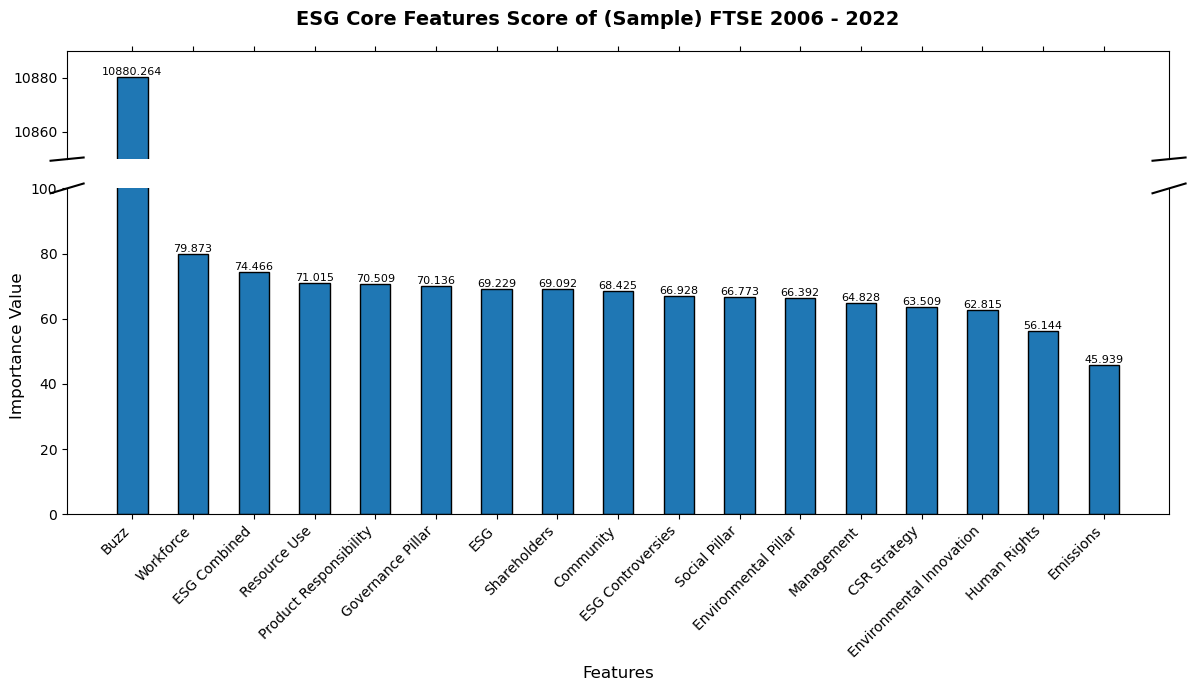

In [687]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already defined importance_values, std, and features

# Sort the features based on values
sorted_indices = np.argsort(values)[::-1]
values = np.array(values)[sorted_indices]
labels = np.array(labels)[sorted_indices]

color = '#1f77b4'

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (12,7), gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0.1)

# Plot data without error bars
bar_width = 0.5
bars1 = ax1.bar(labels, values, color=color, width=bar_width, edgecolor='black')
bars2 = ax2.bar(labels, values, color=color, width=bar_width, edgecolor='black')

# Annotate the bars with their values
for ax in [ax1, ax2]:
    for bar in ax.patches:
        yval = bar.get_height()
        ax.annotate(f'{yval:.3f}', (bar.get_x() + bar.get_width() / 2, yval), ha='center', va='bottom', fontsize=8)

# Set y-limits
ax1.set_ylim(10850, 10890)
ax2.set_ylim(0, 100)

# Hide the spines between subplots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)

# Rotate x-labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

# Break marks for y-axis
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Add a title and y-labels
fig.suptitle('ESG Core Features Score of (Sample) FTSE 2006 - 2022', fontsize=14, fontweight='bold')
ax2.set_xlabel('Features', fontsize=12)
fig.text(0.01, 0.5, 'Importance Value', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()


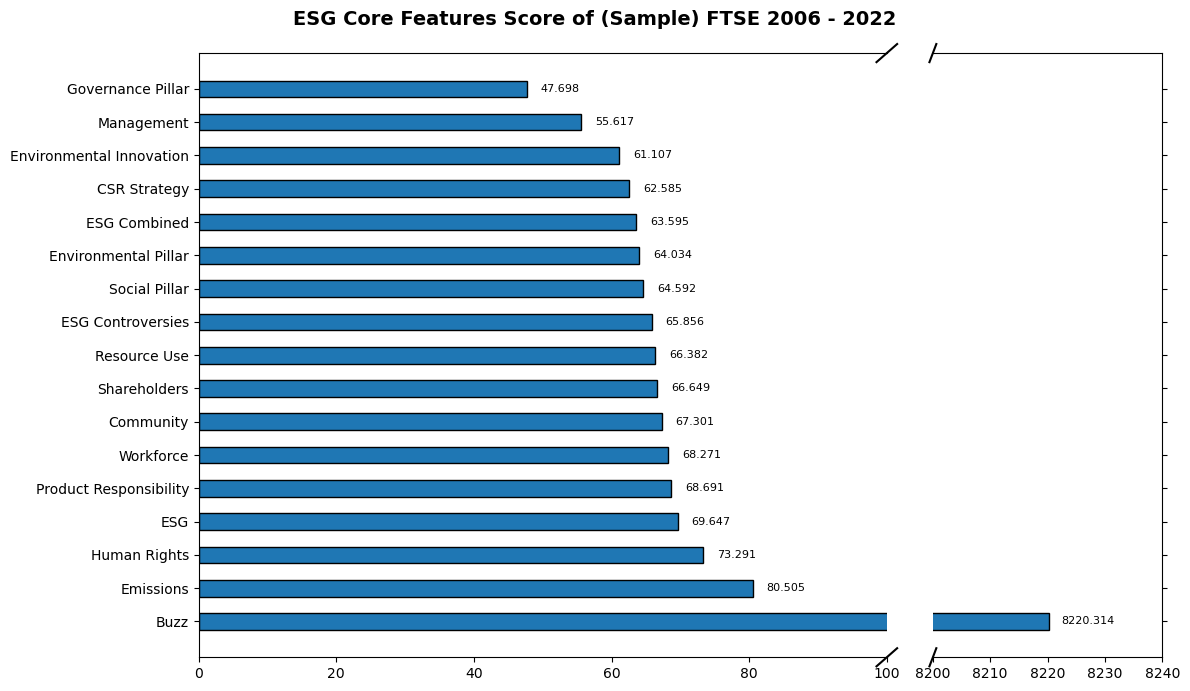

In [636]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already defined importance_values, std, and features

# Sort the features based on values
sorted_indices = np.argsort(values)[::-1]
values = np.array(values)[sorted_indices]
labels = np.array(labels)[sorted_indices]

color = '#1f77b4'

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,7), gridspec_kw={'width_ratios': [3, 1]})
fig.subplots_adjust(wspace=0.1)  # Adjust space between axes

# Plot data without error bars in horizontal mode
bar_height = 0.5
bars1 = ax1.barh(labels, values, color=color, height=bar_height, edgecolor='black')
bars2 = ax2.barh(labels, values, color=color, height=bar_height, edgecolor='black')

# Annotate the bars with their values
for ax in [ax1, ax2]:
    for bar in ax.patches:
        xval = bar.get_width()
        ax.annotate(f'{xval:.3f}', (xval+2, bar.get_y() + bar.get_height() / 2), ha='left', va='center', fontsize=8)

# Set x-limits
ax1.set_xlim(0, 100)
ax2.set_xlim(8200, 8240)

# Hide the spines between subplots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.tick_params(labelleft=False)

# Adjust y-labels for better visibility
plt.setp(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)

# Break marks for x-axis
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([1-d, 1+d], [-d, +d], **kwargs)   # right-bottom diagonal
ax1.plot([1-d, 1+d], [1-d, 1+d], **kwargs) # right-top diagonal
kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [-d, +d], **kwargs)     # left-bottom diagonal
ax2.plot([-d, +d], [1-d, 1+d], **kwargs)   # left-top diagonal

# Add a title and x-labels
fig.suptitle('ESG Core Features Score of (Sample) FTSE 2006 - 2022', fontsize=14, fontweight='bold')
# fig.text(0.5, 0.01, 'Importance Value', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [652]:
len(esg_df.Asset.unique())

219

In [693]:
sub_esg_df = esg_df.iloc[:,3:]

In [708]:
agg_sub_esg_df = sub_esg_df.groupby(['Economic Sector']).describe().loc[:, (slice(None), ['mean'])]

In [712]:
sectors_df

,sectors,num_firms
0,Basic materials,11
1,Consumer cyclicals,15
2,Consumer non-cyclicals,13
3,Energy,2
4,Financials,15
5,Healthcare,4
6,Industrials,13
7,Real estate,3
8,Technology,3
9,Utilities,5


In [710]:
agg_sub_esg_df.T

,Economic Sector,Basic materials,Consumer cyclicals,Consumer non-cyclicals,Energy,Financials,Healthcare,Industrials,Real estate,Technology,Utilities
buzz,mean,5655.782051,1529.757218,7015.951342,128249.808185,13315.530233,13948.826253,6750.793195,761.280667,11241.549323,5865.363885
ESG,mean,66.168416,67.355578,66.421937,75.074577,73.553953,74.893980,68.793704,67.503850,72.678675,66.115057
ESGCombined,mean,55.049602,60.316895,54.388804,51.855506,55.593527,55.988855,53.852314,61.618752,57.717333,55.760052
ESGControversies,mean,45.957113,58.287231,46.965784,28.628456,38.714232,37.837302,40.646235,66.571186,43.897825,47.498884
EnvironmentalPillar,mean,69.758287,59.551776,61.637901,79.005135,72.735712,70.482425,62.573798,68.718494,73.358982,68.841630
GovernancePillar,mean,64.295248,72.480002,70.764424,69.398009,73.359179,78.316155,73.245545,69.520095,69.232738,65.735751
SocialPillar,mean,65.244008,69.719516,66.822657,76.804234,74.492989,75.743951,71.383161,67.970948,75.317270,63.434320
CSRStrategy,mean,58.243004,50.741988,67.530172,80.834492,67.929094,58.238377,60.357071,69.465358,63.878110,60.622565
Community,mean,83.720593,86.469745,84.620060,73.337336,74.197325,84.222804,74.518309,75.465818,83.976984,71.922238
Emissions,mean,68.069517,63.156757,65.102155,69.250672,72.309674,75.347306,65.438226,78.521732,73.596628,78.001846


In [696]:
sub_esg_df.groupby(['Economic Sector']).describe().T

Economic Sector  Basic materials  Consumer cyclicals  Consumer non-cyclicals  \
buzz      count     50482.000000        74400.000000            71077.000000   
          mean       5655.782051         1529.757218             7015.951342   
          std       10317.233770         1732.389908            11408.657282   
          min           5.000000            1.000000               38.000000   
          25%         513.500000          393.875000              638.500000   
...                          ...                 ...                     ...   
Workforce min           1.000000            1.000000                1.000000   
          25%          24.000000           45.000000               48.000000   
          50%          70.000000           76.000000               80.000000   
          75%          86.000000           92.000000               91.000000   
          max         100.000000          100.000000              100.000000   

Economic Sector         Energy    Financials    Healthcare   Industrials  \
buzz      count   12658.000000  88215.000000  20996.000000  55110.000000   
          mean   128249.808185  13315.530233  13948.826253   6750.793195   
          std    158202.455383  19567.234926  33846.518555   8157.680625   
          min     27806.000000     21.500000    388.000000    103.500000   
          25%     58231.375000   1283.000000   1749.500000   1223.500000   
...                        ...           ...           ...           ...   
Workforce min         1.000000      1.000000      1.000000      1.000000   
          25%        77.000000     70.000000     67.000000     64.000000   
          50%        86.000000     85.000000     85.000000     83.000000   
          75%        91.000000     93.000000     93.000000     92.000000   
          max        99.000000    100.000000    100.000000    100.000000   

Economic Sector   Real estate    Technology     Utilities  
buzz      count  15326.000000  18987.000000  30915.000000  
          mean     761.280667  11241.549323   5865.363885  
          std      760.292777  14931.391762   8413.102755  
          min        2.000000    176.000000     26.000000  
          25%       80.500000   1075.500000   1184.500000  
...                       ...           ...           ...  
Workforce min        1.000000      1.000000      1.000000  
          25%       47.000000     51.000000     39.000000  
          50%       77.000000     85.000000     69.000000  
          75%       92.000000     92.000000     84.000000  
          max      100.000000    100.000000    100.000000  

[136 rows x 10 columns]

# Out of sample Results

In [34]:
import glob

In [807]:
# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/04-RF-m1-*.csv")

master_rf_m1 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_rf_m1 = pd.concat([master_rf_m1, temp_df])
    
np.mean(master_rf_m1['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/04-RF-m2-*.csv")

master_rf_m2 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_rf_m2 = pd.concat([master_rf_m2, temp_df])
    
np.mean(master_rf_m2['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/04-RF-m3-*.csv")

master_rf_m3 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_rf_m3 = pd.concat([master_rf_m3, temp_df])
    
np.mean(master_rf_m3['MSE^3'])

0.008625569223078852

In [808]:
master_rf_m1.index = master_rf_m1.Asset
master_rf_m2.index = master_rf_m2.Asset
master_rf_m3.index = master_rf_m3.Asset

master_rf_m1 = master_rf_m1.rename(columns={'MSE^3': 'RF-M1-MSE^3'})
master_rf_m2 = master_rf_m2.rename(columns={'MSE^3': 'RF-M2-MSE^3'})
master_rf_m3 = master_rf_m3.rename(columns={'MSE^3': 'RF-M3-MSE^3'})

master_rf_m1 = master_rf_m1.iloc[:,[-1]]
master_rf_m2 = master_rf_m2.iloc[:,[-1]]
master_rf_m3 = master_rf_m3.iloc[:,[-1]]

---

In [824]:
# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/03-EN-m1*.csv")

master_EN_m1 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_EN_m1 = pd.concat([master_EN_m1, temp_df])
    
np.mean(master_EN_m1['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/03-EN-m2*.csv")

master_EN_m2 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_EN_m2 = pd.concat([master_EN_m2, temp_df])
    
np.mean(master_EN_m2['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/03-EN-m3*.csv")

master_EN_m3 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_EN_m3 = pd.concat([master_EN_m3, temp_df])
    
np.mean(master_EN_m3['MSE^3'])

0.08156498648014639

In [825]:
master_EN_m1.index = master_EN_m1['Asset']
master_EN_m2.index = master_EN_m2['Asset']
master_EN_m3.index = master_EN_m3['Asset']

master_EN_m1 = master_EN_m1.rename(columns={'MSE^3': 'EN-M1-MSE^3'})
master_EN_m2 = master_EN_m2.rename(columns={'MSE^3': 'EN-M2-MSE^3'})
master_EN_m3 = master_EN_m3.rename(columns={'MSE^3': 'EN-M3-MSE^3'})

master_EN_m1 = master_EN_m1.iloc[:,[-1]]
master_EN_m2 = master_EN_m2.iloc[:,[-1]]
master_EN_m3 = master_EN_m3.iloc[:,[-1]]

---

In [191]:
# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/02-HAR-m1-*.csv")

master_HAR_m1 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_HAR_m1 = pd.concat([master_HAR_m1, temp_df])
    
np.mean(master_HAR_m1['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/02-HAR-m2-*.csv")

master_HAR_m2 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_HAR_m2 = pd.concat([master_HAR_m2, temp_df])
    
np.mean(master_HAR_m2['MSE^3'])

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/02-HAR-m3-*.csv")

master_HAR_m3 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_HAR_m3 = pd.concat([master_HAR_m3, temp_df])

In [192]:
master_HAR_m1.index = master_HAR_m1.Asset
master_HAR_m2.index = master_HAR_m2.Asset
master_HAR_m3.index = master_HAR_m3.Asset

master_HAR_m1 = master_HAR_m1.rename(columns={'MSE^3': 'HAR-M1-MSE^3'})
master_HAR_m2 = master_HAR_m2.rename(columns={'MSE^3': 'HAR-M2-MSE^3'})
master_HAR_m3 = master_HAR_m3.rename(columns={'MSE^3': 'HAR-M3-MSE^3'})

master_HAR_m1 = master_HAR_m1.iloc[:,[-1]]
master_HAR_m2 = master_HAR_m2.iloc[:,[-1]]
master_HAR_m3 = master_HAR_m3.iloc[:,[-1]]

---

In [193]:
csv_files = glob.glob("../results/04-RF-m1-*.csv")

tt_df = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    tt_df = pd.concat([tt_df, temp_df])

list_asset_name_df = tt_df.iloc[:, :2]

In [194]:
# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/LSTM-m1-All-N3*.csv")

master_LSTM_m1 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_LSTM_m1 = pd.concat([master_LSTM_m1, temp_df])

master_LSTM_m1['MSE^3'] = master_LSTM_m1['MSE'] * 10**3
master_LSTM_m1 = pd.merge(master_LSTM_m1, list_asset_name_df, how = 'inner', left_on='Firm', right_on = 'Name')
    

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/LSTM-m2-All-N3*.csv")

master_LSTM_m2 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_LSTM_m2 = pd.concat([master_LSTM_m2, temp_df])

master_LSTM_m2['MSE^3'] = master_LSTM_m2['MSE'] * 10**3
master_LSTM_m2 = pd.merge(master_LSTM_m2, list_asset_name_df, how = 'inner', left_on='Firm', right_on = 'Name')
    

# Get a list of all csv files that start with "LSTM-m1-"
csv_files = glob.glob("../results/LSTM-m3-All-N3*.csv")

master_LSTM_m3 = pd.DataFrame()

# Print the list of csv files
for file in csv_files:
    temp_df = pd.read_csv(file)
    master_LSTM_m3 = pd.concat([master_LSTM_m3, temp_df])

master_LSTM_m3['MSE^3'] = master_LSTM_m3['MSE'] * 10**3
master_LSTM_m3 = pd.merge(master_LSTM_m3, list_asset_name_df, how = 'inner', left_on='Firm', right_on = 'Name')

In [195]:
master_LSTM_m1.index = master_LSTM_m1.Asset
master_LSTM_m2.index = master_LSTM_m2.Asset
master_LSTM_m3.index = master_LSTM_m3.Asset

master_LSTM_m1 = master_LSTM_m1.rename(columns={'MSE^3': 'LSTM-M1-MSE^3'})
master_LSTM_m2 = master_LSTM_m2.rename(columns={'MSE^3': 'LSTM-M2-MSE^3'})
master_LSTM_m3 = master_LSTM_m3.rename(columns={'MSE^3': 'LSTM-M3-MSE^3'})

master_LSTM_m1 = master_LSTM_m1.iloc[:,[-3]]
master_LSTM_m2 = master_LSTM_m2.iloc[:,[-3]]
master_LSTM_m3 = master_LSTM_m3.iloc[:,[-3]]

In [826]:
result_merge_df = pd.concat([master_HAR_m1, master_HAR_m2, master_HAR_m3, 
                             master_EN_m1, master_EN_m2, master_EN_m3, 
                             master_rf_m1, master_rf_m2, master_rf_m3, 
                             master_LSTM_m1, master_LSTM_m2, master_LSTM_m3], axis=1)

In [207]:
result_m1 = pd.concat([master_HAR_m1, master_EN_m1, master_rf_m1,], axis=1)
result_m2 = pd.concat([master_HAR_m2, master_EN_m2, master_rf_m2,], axis=1)
result_m3 = pd.concat([master_HAR_m3, master_EN_m3, master_rf_m3,], axis=1)

In [213]:
result_wo_lstm = pd.concat([master_HAR_m1, master_HAR_m2, master_HAR_m3, 
                            master_EN_m1, master_EN_m2, master_EN_m3,
                            master_rf_m1, master_rf_m2, master_rf_m3], axis=1)

In [224]:
result_wo_lstm.columns = ['HAR M1', 'HAR M2', 'HAR M3', 'EN M1', 'EN M2', 'EN M3',
                         'RF M1', 'RF M2', 'RF M3']

In [427]:
def viz_boxplot_result(df, orient = 'v', title = ''):
    # Plotting
    plt.figure(figsize=(10, 6))

    # Box plot settings
    boxplot_kwargs = {
        'boxprops': {'facecolor': 'none', 'edgecolor': 'blue'},
        'whiskerprops': {'color': 'black', 'linestyle': '--'},
        'capprops': {'color': 'black'},
        'medianprops': {'color': 'red'},
        'flierprops': {'marker': 'o', 'markerfacecolor': 'none', 'markeredgecolor': 'red', 'markersize': 8}
    }

    # Using seaborn's boxplot function
    ax = sns.boxplot(data=df, width = .2, orient = orient, **boxplot_kwargs)

    # Rotate x-axis labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Removing horizontal grid lines and adding vertical grid lines
    ax.xaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
    ax.set_title(title)

    # Set the maximum y-value to 1
    if orient == 'v':
        ax.set_ylim(bottom=0, top=0.2)
        
    # Set the maximum y-value to 1
    else:
        ax.set_aspect('auto')
        ax.set_xlim(xmin= -0.01, xmax = 0.2)


        

    plt.tight_layout()
    plt.show()

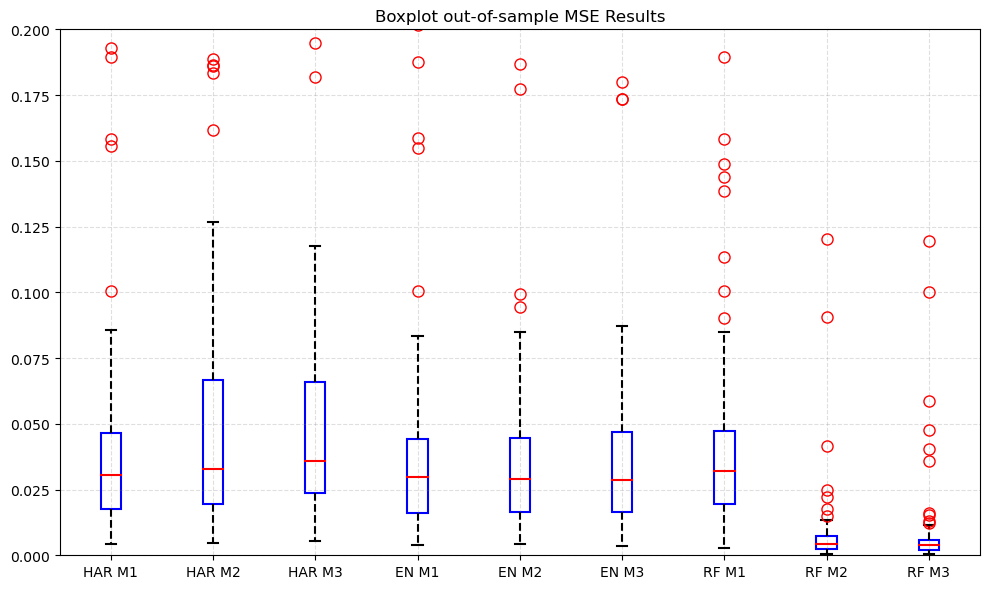

In [230]:
viz_boxplot_result(result_wo_lstm, 'Boxplot out-of-sample MSE Results')

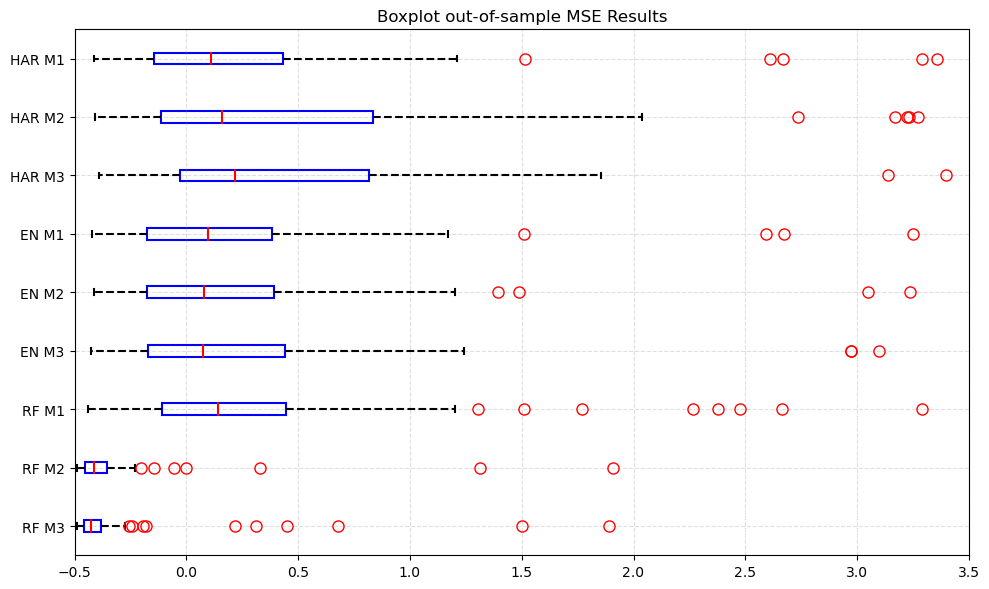

In [418]:
viz_boxplot_result(result_wo_lstm, orient= 'v', title = 'Boxplot out-of-sample MSE Results')

---

## Median Comparison between EN and HAR

In [827]:
lnear_model_results = pd.concat([# master_HAR_m1, master_HAR_m2, master_HAR_m3, 
                            master_EN_m1, master_EN_m2, master_EN_m3], axis=1)

In [828]:
lnear_model_results.columns = ['EN M1', 'EN M2', 'EN M3']

In [829]:
lnear_model_results.describe()

,EN M1,EN M2,EN M3
count,85.000000,85.000000,85.000000
mean,0.091273,0.081565,0.081565
std,0.286195,0.233617,0.233617
min,0.003461,0.003461,0.003461
25%,0.014336,0.015403,0.015403
50%,0.027388,0.027009,0.027009
75%,0.050413,0.049952,0.049952
max,2.260294,1.827005,1.827005


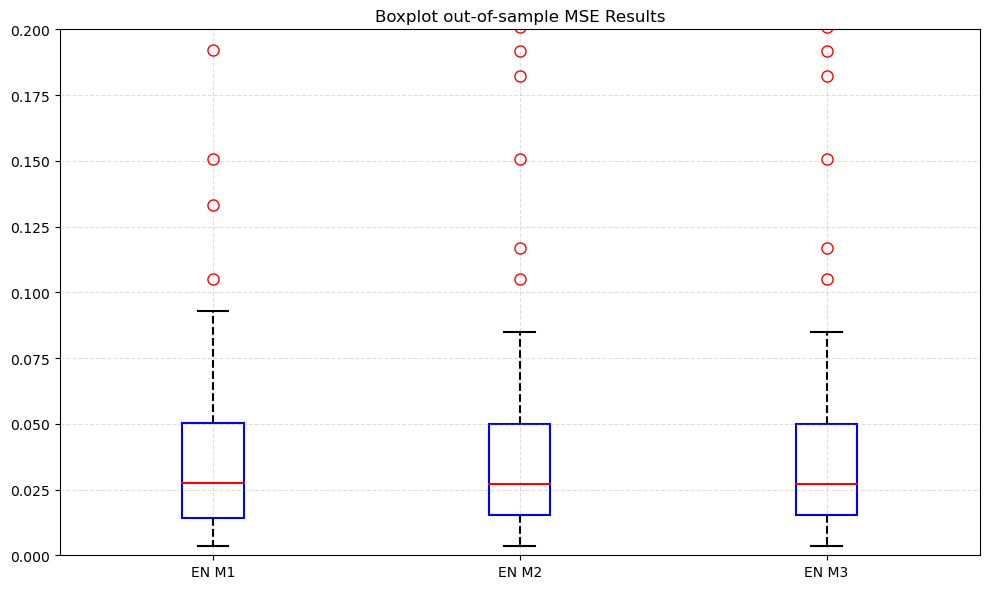

In [830]:
viz_boxplot_result(lnear_model_results, orient= 'v', title = 'Boxplot out-of-sample MSE Results')

---

## Comparison Random Forest

In [434]:
RF_model_results = pd.concat([
                            master_rf_m1, master_rf_m2, master_rf_m3], axis=1)

In [435]:
RF_model_results.columns = ['EN M1', 'EN M2', 'EN M3']

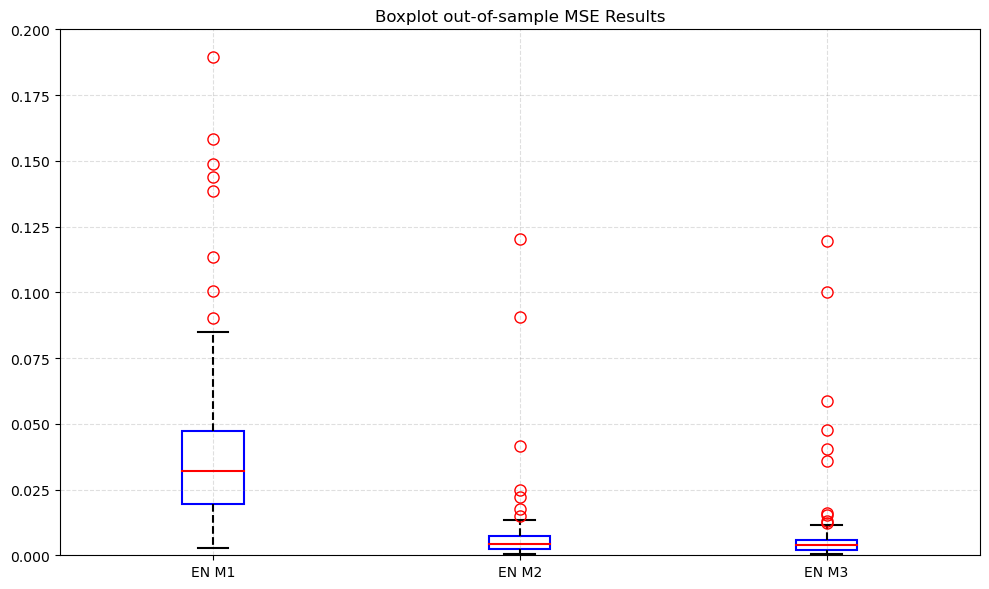

In [436]:
viz_boxplot_result(RF_model_results, orient= 'v', title = 'Boxplot out-of-sample MSE Results')

In [441]:
lnear_model_results[lnear_model_results.index == 8589934212]

,HAR-M1-MSE^3,HAR-M2-MSE^3,HAR-M3-MSE^3,EN-M1-MSE^3,EN-M2-MSE^3,EN-M3-MSE^3
8589934212,0.064597,0.065423,0.066919,0.06846,0.065277,0.065557


In [442]:
lnear_model_results[lnear_model_results['HAR-M3-MSE^3'] < lnear_model_results['EN-M3-MSE^3']]

,HAR-M1-MSE^3,HAR-M2-MSE^3,HAR-M3-MSE^3,EN-M1-MSE^3,EN-M2-MSE^3,EN-M3-MSE^3
4295897408,0.031899,0.031026,0.031047,0.031168,0.030120,0.045999
4295869210,0.021690,0.015391,0.018203,0.023148,0.043862,0.032932
4295898928,0.024741,0.040063,0.027664,0.025024,0.027121,0.028346
4295898044,0.029846,0.030545,0.026286,0.029773,0.029007,0.032996
5036383104,0.057992,0.079034,0.059376,0.064197,0.060947,0.073768
4295898932,0.053924,0.063602,0.054428,0.053921,0.079598,0.079598
4295895815,1.028604,1.860856,1.075571,1.093944,1.093944,1.093944
4295894667,0.035464,0.075314,0.048192,0.035428,0.034271,0.054650
5001229906,0.079474,0.096607,0.076649,0.082650,0.072279,0.078813
4295897734,0.024620,0.024937,0.025123,0.024749,0.025246,0.026356


In [440]:
unique_assets_df[unique_assets_df['Firm Name'] == 'Natwest Group PLC']

,Asset,Firm Name,Economic Sector
35,8589934212,Natwest Group PLC,Financials


In [445]:
unique_assets_df[unique_assets_df['Asset'] == 4295869210]


,Asset,Firm Name,Economic Sector
3,4295869210,TUI AG,Consumer cyclicals


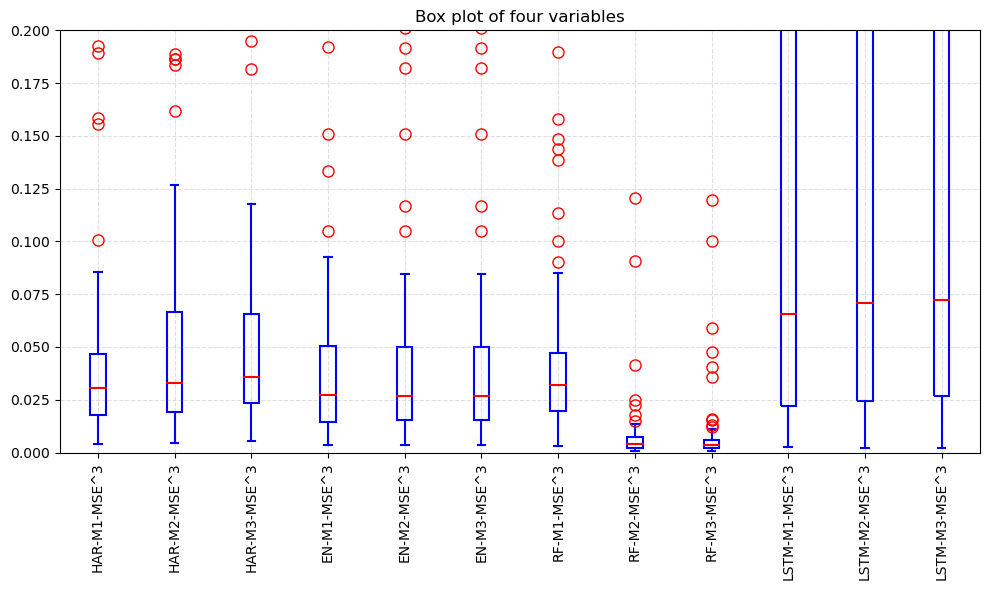

In [831]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create dummy data
np.random.seed(42)

# Plotting
plt.figure(figsize=(10, 6))

# Box plot settings
boxplot_kwargs = {
    'boxprops': {'facecolor': 'none', 'edgecolor': 'blue'},
    'whiskerprops': {'color': 'blue'},
    'capprops': {'color': 'blue'},
    'medianprops': {'color': 'red'},
     'flierprops': {'marker': 'o', 'markerfacecolor': 'none', 'markeredgecolor': 'red', 'markersize': 8}
}

# Using seaborn's boxplot function
ax = sns.boxplot(data=result_merge_df, width = .2, **boxplot_kwargs)

# Rotate x-axis labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Removing horizontal grid lines and adding vertical grid lines
ax.xaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
ax.set_title("Box plot of four variables")

# Set the maximum y-value to 1
ax.set_ylim(bottom=0, top=0.2)

plt.tight_layout()
plt.show()

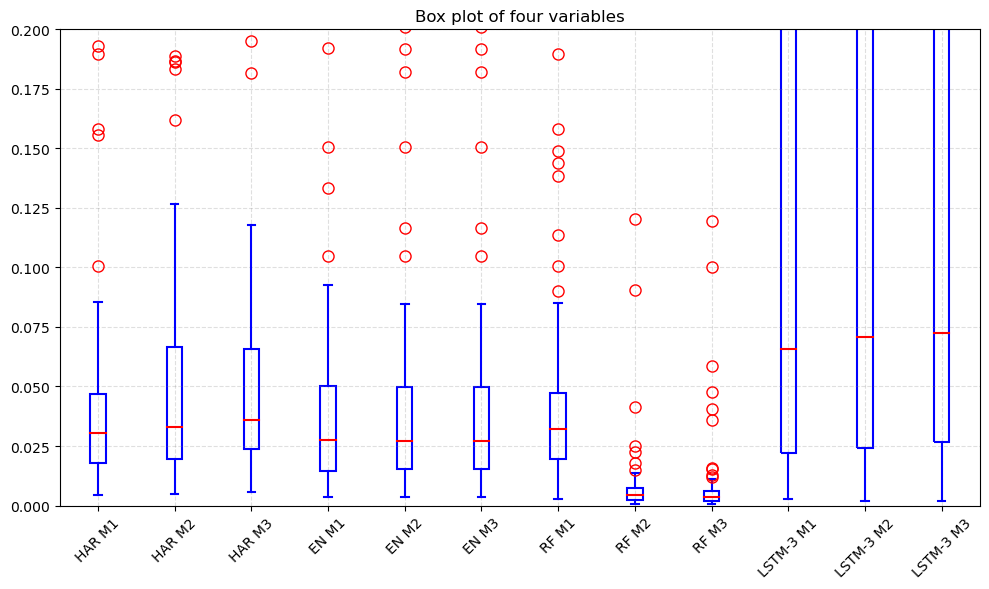

In [834]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create dummy data
np.random.seed(42)

# Plotting
plt.figure(figsize=(10, 6))

# Box plot settings
boxplot_kwargs = {
    'boxprops': {'facecolor': 'none', 'edgecolor': 'blue'},
    'whiskerprops': {'color': 'blue'},
    'capprops': {'color': 'blue'},
    'medianprops': {'color': 'red'},
     'flierprops': {'marker': 'o', 'markerfacecolor': 'none', 'markeredgecolor': 'red', 'markersize': 8}
}

# Using seaborn's boxplot function
ax = sns.boxplot(data=result_merge_df, width = .2, **boxplot_kwargs)

# Rotate x-axis labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Removing horizontal grid lines and adding vertical grid lines
ax.xaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
ax.set_title("Box plot of four variables")

# Set the maximum y-value to 1
ax.set_ylim(bottom=0, top=0.2)

plt.tight_layout()
plt.show()

In [833]:
result_merge_df.columns = ['HAR M1', 'HAR M2', 'HAR M3',
                           'EN M1', 'EN M2', 'EN M3',
                           'RF M1', 'RF M2', 'RF M3',
                           'LSTM-3 M1', 'LSTM-3 M2', 'LSTM-3 M3'
                          ]

---

# Correlation

In [361]:
import sys, os
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
sys.path.append('../python')
pd.set_option('display.max_columns', 100)
from dataprocessingnew2 import *

In [332]:
coverage_df = pd.read_csv('../data/coverage_dataframe.csv')[['PermID', 'Name', 'TRBCEconomicSector']]
coverage_df['PermID'] = coverage_df.PermID.astype(int)

unique_assets_df = pd.DataFrame({
    'Assets': train_df.Asset.unique()
})

unique_assets_df = pd.merge(unique_assets_df, coverage_df, how = 'left', left_on = 'Assets', right_on= 'PermID')
unique_assets_df = unique_assets_df.iloc[:, 1:]
unique_assets_df.columns = ['Assets', 'Firm Name', 'Economic Sector']

sectors_df = pd.DataFrame(np.unique(unique_assets_df['Economic Sector'], return_counts=True)).T
sectors_df.columns = ['sectors','num_firms']

In [362]:
dataprocessing = DataProcessing('2006-01-01', '2022-12-01', daily=True)
df_clean, train_df, test_df = dataprocessing.clean_final(fillna = True)

209
(389669, 25)


In [333]:
df_1 = clean_df[['Asset', 'V^YZ']].reset_index(drop=True)

In [334]:
unique_assets_df = unique_assets_df.rename(columns={'Assets':'Asset'})

In [335]:
df_1 = pd.merge(df_1, unique_assets_df, how = 'left', on = 'Asset')

In [259]:
df_1[['Firm Name', 'V^YZ']].groupby(['Firm Name']).describe().sort_values(df_1_agg.columns[1], ascending=False)

V^YZ                                                    \
                     count      mean       std       min       25%       50%   
Firm Name                                                                      
EVRAZ plc           1336.0  0.029011  0.013096  0.014488  0.022360  0.026136   
Natwest Group PLC   4274.0  0.028039  0.021937  0.007988  0.016420  0.022167   
Barclays PLC        4274.0  0.027610  0.020333  0.009839  0.016315  0.021257   
Anglo American PLC  4274.0  0.027599  0.013070  0.012858  0.019897  0.023738   
Fresnillo PLC       3435.0  0.027402  0.011880  0.014278  0.021069  0.025154   
...                    ...       ...       ...       ...       ...       ...   
Relx PLC            4274.0  0.014611  0.007909  0.006246  0.010344  0.012768   
Diageo PLC          4274.0  0.014209  0.006889  0.007439  0.010332  0.012494   
Bunzl plc           3381.0  0.014106  0.006487  0.007188  0.010881  0.012838   
National Grid PLC   4274.0  0.014092  0.005937  0.006746  0.010699  0.012707   
Unilever PLC        4274.0  0.013808  0.005612  0.006811  0.010420  0.012471   

                                        
                         75%       max  
Firm Name                               
EVRAZ plc           0.030453  0.125247  
Natwest Group PLC   0.030331  0.186205  
Barclays PLC        0.029878  0.159668  
Anglo American PLC  0.030140  0.102035  
Fresnillo PLC       0.029683  0.130369  
...                      ...       ...  
Relx PLC            0.015251  0.068148  
Diageo PLC          0.015593  0.066480  
Bunzl plc           0.015299  0.077316  
National Grid PLC   0.015508  0.055680  
Unilever PLC        0.014968  0.052589  

[84 rows x 8 columns]

In [261]:
df_1[['Economic Sector', 'V^YZ']].groupby(['Economic Sector']).describe().sort_values(df_1_agg.columns[1], ascending=False)

V^YZ                                          \
                          count      mean       std       min       25%   
Economic Sector                                                           
Basic materials         33411.0  0.024056  0.011877  0.006963  0.017186   
Financials              59220.0  0.021574  0.015688  0.001411  0.013558   
Consumer cyclicals      48122.0  0.019483  0.010919  0.007005  0.013635   
Industrials             36444.0  0.018402  0.011099  0.004483  0.012582   
Technology              12822.0  0.017958  0.007827  0.008284  0.013120   
Energy                   8548.0  0.017453  0.009301  0.006544  0.011965   
Real estate              8951.0  0.017000  0.010119  0.006906  0.011289   
Healthcare              14125.0  0.016463  0.006905  0.006942  0.011988   
Consumer non-cyclicals  47490.0  0.016206  0.007639  0.006687  0.011779   
Utilities               20058.0  0.015559  0.007147  0.006746  0.011511   

                                                      
                             50%       75%       max  
Economic Sector                                       
Basic materials         0.021366  0.027119  0.162562  
Financials              0.017144  0.023124  0.186205  
Consumer cyclicals      0.016851  0.021660  0.152206  
Industrials             0.015745  0.020251  0.144888  
Technology              0.016048  0.020155  0.078566  
Energy                  0.015221  0.019897  0.104232  
Real estate             0.013894  0.019424  0.105188  
Healthcare              0.014989  0.018536  0.065996  
Consumer non-cyclicals  0.014382  0.018185  0.107738  
Utilities               0.013803  0.017259  0.095370

In [262]:
df_1

,Asset,V^YZ,Firm Name,Economic Sector
0,4295885039,0.009532,Shell PLC,Energy
1,4295885039,0.009865,Shell PLC,Energy
2,4295885039,0.009851,Shell PLC,Energy
3,4295885039,0.009874,Shell PLC,Energy
4,4295885039,0.009715,Shell PLC,Energy
...,...,...,...,...
292640,4295874865,0.012386,DCC PLC,Consumer non-cyclicals
292641,4295874865,0.012339,DCC PLC,Consumer non-cyclicals
292642,4295874865,0.012284,DCC PLC,Consumer non-cyclicals
292643,4295874865,0.012714,DCC PLC,Consumer non-cyclicals


In [379]:
clean_df.head(1)

,Date (shifted),Asset,Open,High,Low,Close,Return,V^CC,V^RS,V^YZ,col_merge,date_key,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,Community,EnvironmentalInnovation,Management,ProductResponsibility,Shareholders,Workforce
col_merge,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-04,2006-02-01,4295885039,18.339996,18.439986,18.289993,18.289993,0.001095,0.008094,0.008891,0.009532,2006-01-04,2006-01-04,29777.0,75.0,49.0,23.0,85.0,63.0,78.0,66.0,94.0,75.0,75.0,4.0,78.0


In [380]:
df_2 = clean_df[['Asset', 'ESGControversies']].reset_index(drop=True)

In [381]:
df_2 = pd.merge(df_2, unique_assets_df, how = 'left', on = 'Asset')

In [382]:
df_2_agg = df_2[['Firm Name', 'ESGControversies']].groupby(['Firm Name']).describe()

In [383]:
df_2_agg.sort_values(df_2_agg.columns[1], ascending=False)

ESGControversies                        \
                                             count       mean        std   
Firm Name                                                                  
DCC PLC                                     1768.0  95.576357   5.768388   
SEGRO PLC                                   1623.0  82.334566  20.096704   
Coca Cola HBC AG                            2338.0  79.635586  13.601825   
Kingfisher PLC                              4192.0  72.950859  12.519037   
InterContinental Hotels Group PLC           4274.0  71.073467  11.691996   
...                                            ...        ...        ...   
BAE Systems PLC                             4274.0  22.582592  16.344763   
HSBC Holdings PLC                           4274.0  22.348152   7.878672   
Natwest Group PLC                           4274.0  21.031118  12.221768   
Barclays PLC                                4274.0  18.952270  10.602053   
Experian PLC                                4081.0  10.373683   5.821384   

                                                                   
                                    min   25%   50%    75%    max  
Firm Name                                                          
DCC PLC                            70.0  96.0  98.0  98.00  100.0  
SEGRO PLC                          14.0  79.0  91.0  94.00  100.0  
Coca Cola HBC AG                   34.0  69.0  82.0  90.75   98.0  
Kingfisher PLC                     35.0  66.0  74.0  80.00  100.0  
InterContinental Hotels Group PLC  29.0  66.0  73.0  78.00   93.0  
...                                 ...   ...   ...    ...    ...  
BAE Systems PLC                     1.0   7.0  22.0  33.00   64.0  
HSBC Holdings PLC                   6.0  16.0  23.0  28.00   46.0  
Natwest Group PLC                   5.0  12.0  16.0  28.00   58.0  
Barclays PLC                        5.0  10.0  14.0  26.00   46.0  
Experian PLC                        2.0   6.0   9.0  13.00   35.0  

[84 rows x 8 columns]

In [384]:
df_2_agg_sector = df_2[['Economic Sector', 'ESGControversies']].groupby(['Economic Sector']).describe()

In [385]:
df_2_agg_sector.sort_values(df_2_agg.columns[1], ascending=False)

ESGControversies                                   \
                                  count       mean        std  min   25%   
Economic Sector                                                            
Real estate                      8951.0  65.815104  22.933377  4.0  49.0   
Consumer cyclicals              48122.0  59.072379  18.484869  6.0  46.0   
Consumer non-cyclicals          47490.0  46.955717  21.859324  4.0  31.0   
Utilities                       20058.0  46.617808  17.155943  2.0  34.0   
Basic materials                 33411.0  45.995181  18.447530  5.0  32.0   
Technology                      12822.0  44.073234  18.341410  5.0  30.0   
Industrials                     36444.0  40.263171  22.182731  1.0  20.0   
Financials                      59220.0  38.716565  20.362136  3.0  22.0   
Healthcare                      14125.0  37.676319  16.238405  6.0  26.0   
Energy                           8548.0  28.494736  13.068909  3.0  19.0   

                                           
                         50%   75%    max  
Economic Sector                            
Real estate             65.0  88.0  100.0  
Consumer cyclicals      62.0  73.0  100.0  
Consumer non-cyclicals  44.0  61.0  100.0  
Utilities               48.0  59.0   94.0  
Basic materials         47.0  61.0   93.0  
Technology              44.0  58.0   90.0  
Industrials             42.0  59.0   94.0  
Financials              37.0  54.0   99.0  
Healthcare              37.0  47.0   90.0  
Energy                  30.0  39.0   59.0

In [459]:
cols = [ 'vol_series_daily', 'vol_series_weekly', 'vol_series_monthly',
    'buzz','ESG','ESGCombined','ESGControversies','EnvironmentalPillar','GovernancePillar','SocialPillar','Community',
        'EnvironmentalInnovation','Management','ProductResponsibility','Shareholders','Workforce']
    
#     , 'V^YZ'

In [460]:
merge_df = pd.concat([train_df, test_df])

In [476]:
sub_merge_df = merge_df[cols]

In [478]:
sub_merge_df.columns = ['YZ Daily Lagged', 'YZ Weekly Lagged', 'YZ Monthly Lagged', 
             'Buzz', 'ESG Score', 'ESG Combined', 'ESG Controversies', 
              'Environmental Pillar', 'Governance Pillar', 'Social Pillar', 
              'Community', 'Environmental Innovation', 'Management', 
              'Product Responsibility', 'Shareholders', 'Workforce']

In [488]:
corr = sub_merge_df.corr()
corr = np.round(corr,3)

In [489]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

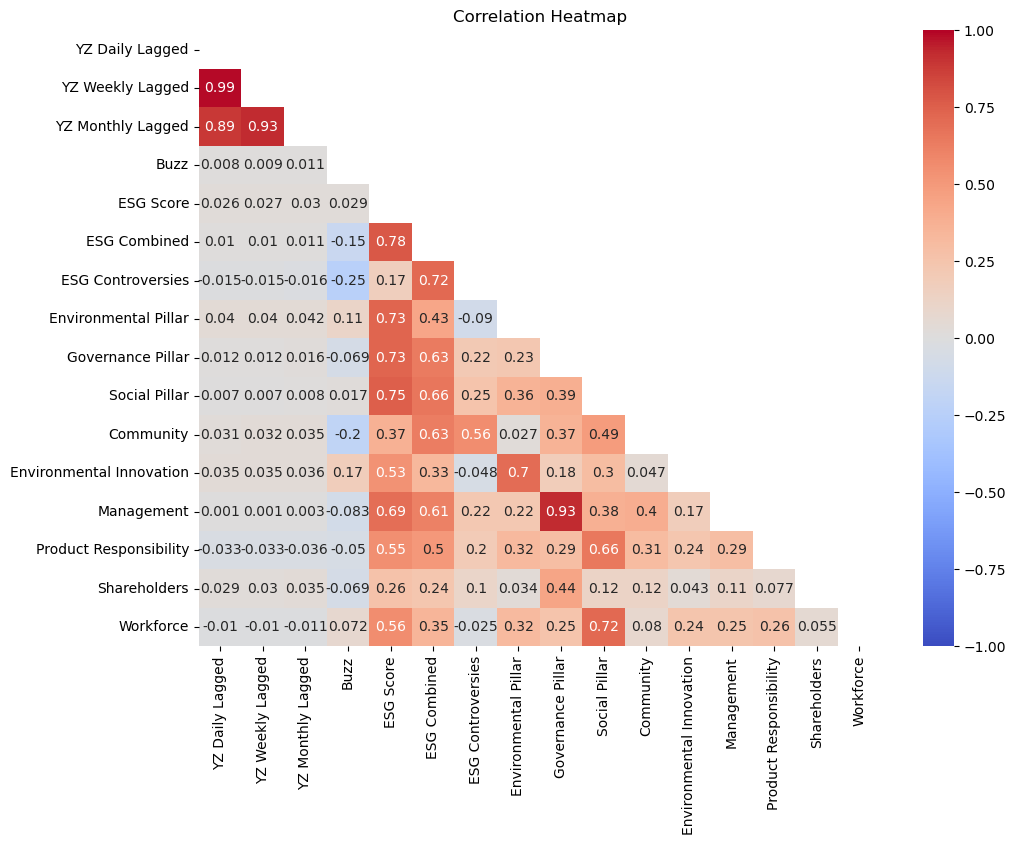

In [490]:
# Create a heatmap
plt.figure(figsize=(11,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=matrix)
plt.title('Correlation Heatmap')
plt.show()

---

In [495]:
cols = ['YZ Daily Lagged', 'YZ Weekly Lagged', 'YZ Monthly Lagged', 
'Buzz', 'Environmental Pillar', 'Community', 'Shareholders']
sub_merge2_df = sub_merge_df[cols]

In [497]:
corr = sub_merge2_df.corr()
corr = np.round(corr,3)
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

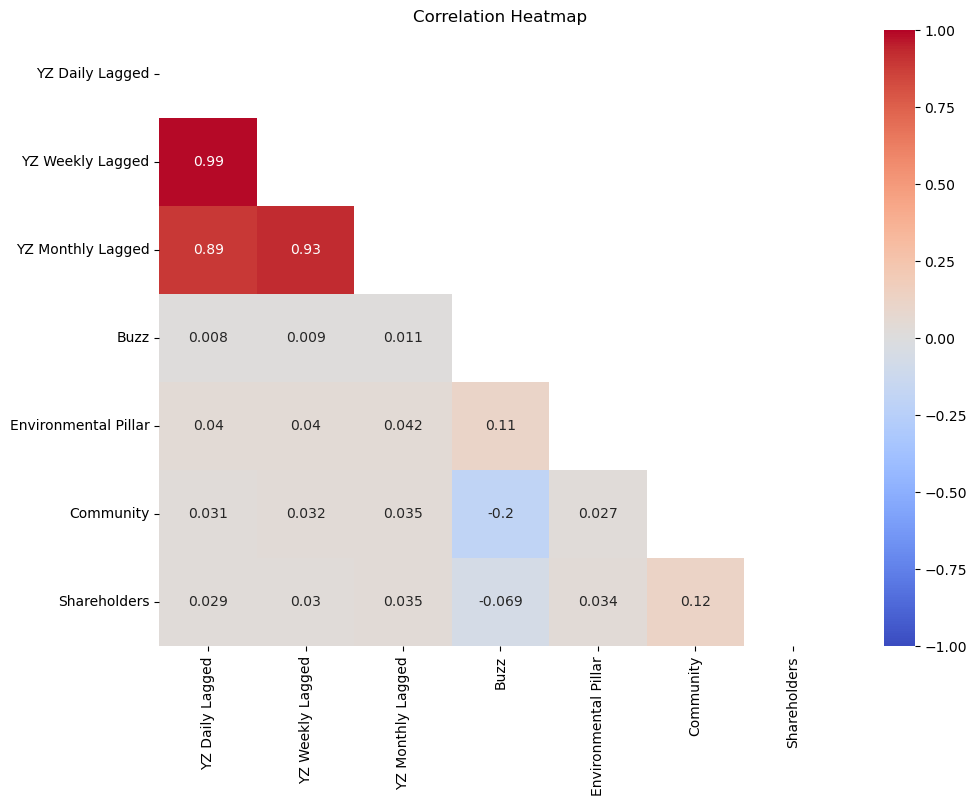

In [498]:
# Create a heatmap
plt.figure(figsize=(11,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=matrix)
plt.title('Correlation Heatmap')
plt.show()

In [347]:
def jump_change_calculation(df):

    master_df = pd.DataFrame()
    blank_days = 30
    for asset in df.Asset.unique():

        temp_df = df[df.Asset == asset].copy()
        temp_df['Date (shifted)'] = pd.to_datetime(temp_df['Date (shifted)'])
        # temp_df.index = temp_df['Date']

        temp_df['Jump'] = temp_df['col_merge'].diff() > timedelta(days=blank_days)
        temp_df['Group'] = temp_df['Jump'].cumsum()
        temp_df['pct_change'] = temp_df.groupby('Group')['Close'].pct_change()
        temp_df.drop(['Group','Jump'], axis=1, inplace=True)

        master_df = pd.concat([master_df,temp_df])

    return master_df.dropna()

In [342]:
cols2 = cols.copy()

In [343]:
cols2.append('pct_change')

In [348]:
clean_2_df = jump_change_calculation(clean_df)

In [350]:
clean_2_df = clean_2_df[cols2]

In [351]:
clean_2_df = clean_2_df[clean_2_df['pct_change'] != 0]

In [355]:
from sklearn.preprocessing import StandardScaler

In [356]:
scaler = StandardScaler()

clean_2_df_trans = scaler.fit_transform(clean_2_df)

In [359]:
corr = pd.DataFrame(clean_2_df_trans).corr()

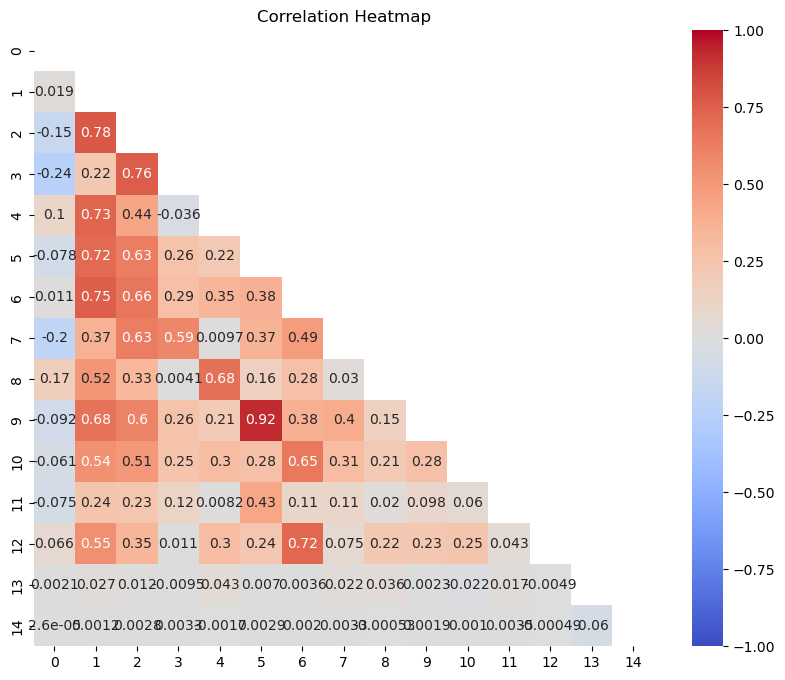

In [360]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=matrix)
plt.title('Correlation Heatmap')
plt.show()

---

# Feature Importance

In [364]:
importances

array([0.01473127, 0.09249108, 0.01963672, 0.01453318, 0.01458774,
       0.34714065, 0.02286501, 0.0184117 , 0.01613808, 0.01570476,
       0.01627351, 0.02870792, 0.01959284, 0.01567078, 0.08034131,
       0.01529252, 0.01628141, 0.01317299, 0.20155912, 0.01686742])

In [365]:
sorted_idx

array([ 5, 18,  1, 14, 11,  6,  2, 12,  7, 19, 16, 10,  8,  9, 13, 15,  0,
        4,  3, 17])

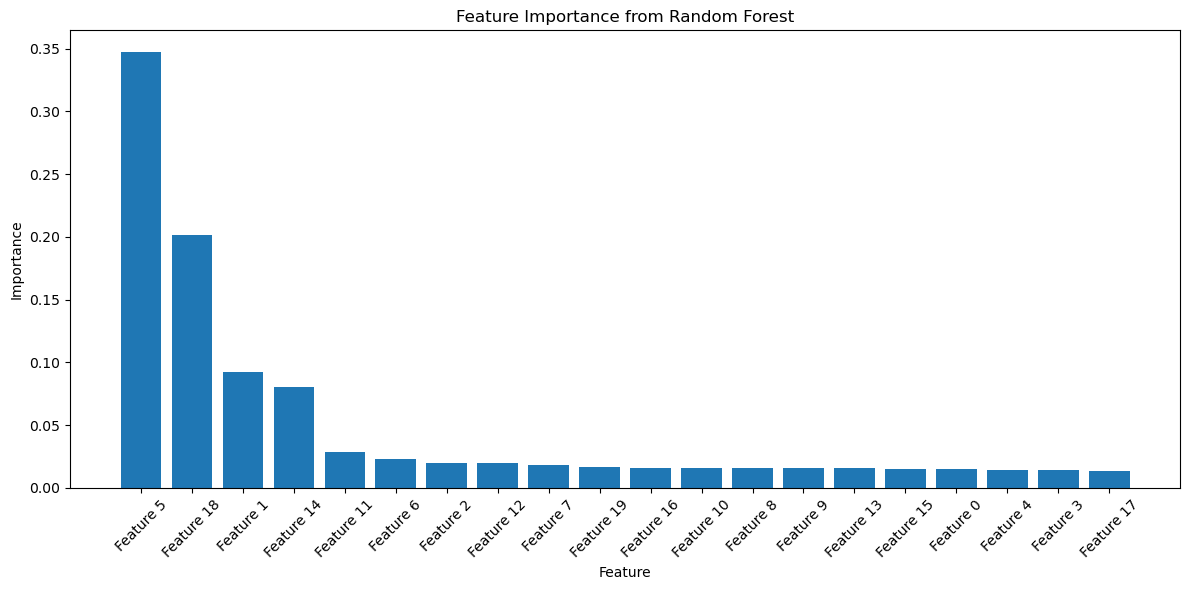

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Generate sample data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Convert to DataFrame for better visualization (optional)
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# 2. Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df['target'], test_size=0.25, random_state=42)

# 3. Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict (optional)
y_pred = clf.predict(X_test)

# 4. Display feature importance
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[sorted_idx], align="center")
plt.xticks(range(X.shape[1]), np.array(feature_names)[sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()


---

In [446]:
import numpy as np
import pandas as pd

# Parameters
T = 1000  # Sample size (you can adjust this)
betas = [0.00, 0.50, 0.75, 0.90]
gammas = [0.25, 0.50, 1.00]

# Simulating a dummy realized volatility series RV_t for the purpose of this example
RV_t = np.random.rand(T)

# Compute sigma_RV squared (sample variance of realized volatility)
sigma_RV2 = np.var(RV_t)
RV_mean = np.mean(RV_t)

# Generating autoregressive noise based on different configurations
all_noises = {}

for beta in betas:
    for gamma in gammas:
        noise_series = np.zeros(T)
        omega = gamma * np.sqrt(sigma_RV2 / (1 - beta**2))
        
        for t in range(1, T):
            epsilon_t = np.random.randn()  # White noise from standard normal distribution
            noise_series[t] = beta * noise_series[t-1] + omega * epsilon_t
        
        key = f'beta_{beta}_gamma_{gamma}'
        all_noises[key] = noise_series

# Convert to DataFrame for better visualization
df_noises = pd.DataFrame(all_noises)

print(df_noises.head())


   beta_0.0_gamma_0.25  beta_0.0_gamma_0.5  beta_0.0_gamma_1.0  \
0             0.000000            0.000000            0.000000   
1             0.012972           -0.101090           -0.018035   
2            -0.097477           -0.205316            0.139993   
3             0.027754           -0.012133            0.255351   
4             0.044571           -0.219683           -0.189726   

   beta_0.5_gamma_0.25  beta_0.5_gamma_0.5  beta_0.5_gamma_1.0  \
0             0.000000            0.000000            0.000000   
1            -0.103546           -0.004085           -0.439270   
2            -0.226726            0.200668           -0.067215   
3            -0.120618           -0.084308           -0.153629   
4            -0.072979           -0.577687           -0.066972   

   beta_0.75_gamma_0.25  beta_0.75_gamma_0.5  beta_0.75_gamma_1.0  \
0              0.000000             0.000000             0.000000   
1             -0.121054             0.098034            -0.347883   

In [447]:
df_noises

,beta_0.0_gamma_0.25,beta_0.0_gamma_0.5,beta_0.0_gamma_1.0,beta_0.5_gamma_0.25,beta_0.5_gamma_0.5,beta_0.5_gamma_1.0,beta_0.75_gamma_0.25,beta_0.75_gamma_0.5,beta_0.75_gamma_1.0,beta_0.9_gamma_0.25,beta_0.9_gamma_0.5,beta_0.9_gamma_1.0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.012972,-0.101090,-0.018035,-0.103546,-0.004085,-0.439270,-0.121054,0.098034,-0.347883,0.047526,0.414473,-0.725367
2,-0.097477,-0.205316,0.139993,-0.226726,0.200668,-0.067215,-0.000065,0.253582,0.029089,-0.195830,0.901671,-1.942513
3,0.027754,-0.012133,0.255351,-0.120618,-0.084308,-0.153629,0.096204,0.323168,0.654781,-0.211826,1.105798,-1.261181
4,0.044571,-0.219683,-0.189726,-0.072979,-0.577687,-0.066972,0.107914,0.471942,-0.116920,-0.241235,1.446945,-0.747165
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.054199,-0.226092,-0.228338,-0.058416,0.191400,0.176450,0.155584,0.143566,0.207447,0.377821,0.145574,0.641126
996,-0.096359,-0.071706,-0.221827,0.025209,0.068012,0.077420,0.245428,0.119253,0.183636,-0.165474,0.373986,0.699904
997,-0.044658,-0.041591,-0.517137,0.014238,0.151606,0.050013,0.282442,0.261567,0.448178,0.115497,0.273719,1.044800
998,-0.002704,-0.037401,0.137686,-0.188462,-0.065146,-0.722682,0.189278,0.113379,-0.446898,0.237044,-0.101563,0.949954


In [713]:
import numpy as np
import pandas as pd

# Simulate realized variance (RV)
T = 1000
RV = np.cumsum(np.random.randn(T))

# Define function to generate noise
def generate_noise(T, beta, gamma, RV):
    epsilon = np.random.randn(T)
    omega = gamma * RV.std() * np.sqrt(1 - beta**2)
    u = np.zeros(T)
    
    for t in range(1, T):
        u[t] = beta * u[t-1] + omega * epsilon[t]
        
    return u

# Noise generation calibrations
betas = [0.00, 0.50, 0.75, 0.90, 0.50, 0.50, 0.50]
gammas_for_betas = [0.25, 0.25, 0.25, 0.25, 0.50, 1.00, 0.25]
gammas = [0.25, 0.50, 1.00]

# Create dataframe
df = pd.DataFrame()
df['RV'] = RV

# Generate noise for M4 (one noise term for each calibration)
for beta, gamma in zip(betas, gammas_for_betas):
    df[f'noise_beta_{beta}_gamma_{gamma}'] = generate_noise(T, beta, gamma, RV)
    
for gamma in gammas:
    df[f'noise_gamma_{gamma}'] = generate_noise(T, 0.50, gamma, RV)  # Assuming β = 0.50 for the second type of noise
    
display(df.head())


,RV,noise_beta_0.0_gamma_0.25,noise_beta_0.5_gamma_0.25,noise_beta_0.75_gamma_0.25,noise_beta_0.9_gamma_0.25,noise_beta_0.5_gamma_0.5,noise_beta_0.5_gamma_1.0,noise_gamma_0.25,noise_gamma_0.5,noise_gamma_1.0
0,0.496714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.358450,2.208762,-3.677593,-1.359443,-0.032491,-1.876009,-5.220974,-1.041931,4.441264,-2.528019
2,1.006138,0.142445,-0.360160,-1.673096,-0.010482,-8.367509,-10.406068,-0.877568,4.283970,-6.207358
3,2.529168,-1.545400,-0.663599,1.727801,0.482694,-5.549508,-9.737718,1.039824,-5.895133,-2.189966
4,2.295015,1.667914,1.131760,2.175227,-0.988820,0.257339,-6.640960,3.163489,-3.590629,8.811711


In [451]:
df

,RV,noise_beta_0.0_gamma_0.25,noise_beta_0.5_gamma_0.25,noise_beta_0.75_gamma_0.25,noise_beta_0.9_gamma_0.25,noise_beta_0.5_gamma_0.5,noise_beta_0.5_gamma_1.0,noise_gamma_0.25,noise_gamma_0.5,noise_gamma_1.0
0,-0.753121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-1.321183,-0.305003,1.024998,-1.724959,-0.516546,4.175777,7.918035,-0.438093,-0.562077,12.812217
2,0.056697,3.771315,1.988639,-1.596203,0.679333,9.578947,8.216868,2.855987,-2.064783,7.766088
3,2.064653,-0.335004,1.313430,-1.019830,0.661594,5.640060,9.788356,2.095900,2.269388,6.083510
4,3.656851,-1.742178,1.641912,-0.369438,0.608130,-0.545355,1.987698,0.109801,0.165170,12.000913
...,...,...,...,...,...,...,...,...,...,...
995,20.857237,4.374566,-2.125316,1.030259,0.198670,-0.819196,-0.177001,1.763126,0.899056,14.494730
996,20.049242,-3.677432,-2.903176,2.242332,0.908586,0.422177,4.512882,1.293663,-0.307695,4.964233
997,21.062133,-2.783520,-2.203545,0.617844,1.092800,-5.045647,14.870336,3.941691,1.532036,9.545395
998,20.726776,-1.018541,0.332620,0.510389,0.759902,-0.338206,1.563771,4.516800,3.607118,3.143193


---

# Noise 3, 15, and 30

In [779]:
EN_M4_df = pd.read_csv('../results/EN-M4-GRIDSEARCH.csv')
EN_M4_df = EN_M4_df.drop_duplicates('Asset IDs')
print(np.mean(EN_M4_df['MSE']))

0.0938031504348146


In [780]:
EN_M4_df = pd.read_csv('../results/EN-M5-GRIDSEARCH.csv')
EN_M4_df = EN_M4_df.drop_duplicates('Asset IDs')
print(np.mean(EN_M4_df['MSE']))

0.09374433101652739


In [781]:
EN_M4_df = pd.read_csv('../results/EN-M6-GRIDSEARCH.csv')
EN_M4_df = EN_M4_df.drop_duplicates('Asset IDs')
print(np.mean(EN_M4_df['MSE']))

0.09478034617672648


In [777]:
EN_M4_df['MSE']

,L1 Ratio,Alpha,Best Scores,MSE,Asset IDs
0,0.6,0.001,0.077503,0.084326,4295874865
1,0.7,0.010,0.102921,0.016746,4295893899
2,0.9,0.001,0.068044,0.045999,4295897408
3,0.3,0.010,0.063637,0.032932,4295869210
4,0.3,0.010,0.174025,0.028346,4295898928
...,...,...,...,...,...
80,0.2,0.010,0.024134,0.013515,4295894468
81,0.2,0.010,0.052453,0.007488,4295894341
82,0.0,1.000,0.051796,0.025182,4295894191
83,0.4,0.010,0.197445,0.037176,4295894068


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def vis_line_plot_results(y_pred, y_test, name, r, algorithms, features):

    dictionaries = {
        'EN': 'Elastic Net',
        'RF': 'Random Forest',
        'LSTM': 'Long Short-Term Memory',
        'HAR': 'Heterogeneous AutoRegressive',
        'GARCH': 'Generalised AutoRegressive Conditional Heteroskedasticity'
    }

    # Calculate absolute differences between actual and predicted values
    diff = np.abs(y_test - y_pred)

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Use Latex style
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot actual and predicted values
    ax1.plot(y_test, alpha = 0.7, color = 'black', linewidth=1)
    ax1.plot(y_pred, marker='.', linestyle='-', linewidth=1, markersize=3)
    ax1.legend([r'True Volatility', r'Predicted Volatility'], fontsize=9, loc='upper left')
    ax1.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1.set_ylabel(r'Volatility', fontsize=9)
    ax1.set_ylim([np.min(y_test)-np.min(y_test)*.5, np.max(y_test)+np.max(y_test)*.05]) 

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot differences on the secondary y-axis as a bar chart
    ax2.bar(y_test.index, diff, color='gray', alpha=0.5, width=1)
    ax2.legend([r'Absolute Difference'], fontsize=9, loc='upper right')
    ax2.set_ylabel(r'Absolute Difference', fontsize=9)
    ax2.set_ylim([0, np.max(diff)*3]) 

    # Set main title
    plt.title(rf'{dictionaries[algorithms]} Prediction on "{name}" [Data:{features}]', fontsize=12)

    # Optimize layout
    plt.tight_layout()
    plt.savefig(f'{str(r+1).zfill(3)}-{algorithms}-{name}.png')
    plt.show()

    # plt.savefig(f'../outputs/{algorithms}-{features}/{str(r+1).zfill(3)}-{algorithms}-{name}.png')
    plt.close()

# Sample usage:
# vis_line_plot_results(y_pred_sample, y_test_sample, "Asset 1", 0, "LSTM", "All Features")


In [11]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.checkdep_usetex(True))

True


<ipython-input-11-fcfd74f1b240>:3: MatplotlibDeprecationWarning: The checkdep_usetex function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use a vendored copy of this function instead.
  print(matplotlib.checkdep_usetex(True))


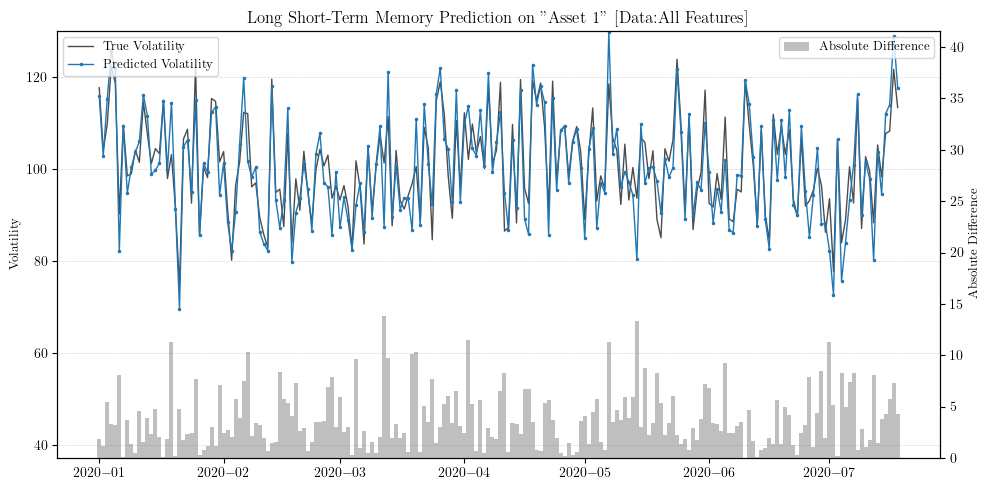

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a random time series with 200 data points for y_test (actual values)
np.random.seed(0)
y_test = pd.Series(100 + np.random.normal(0, 10, 200), name='y_test')

# Create a time series for y_pred (predicted values) which is close to y_test
y_pred = y_test + np.random.normal(0, 5, 200)
y_pred = pd.Series(y_pred, name='y_pred')

# Ensure both Series have the same index
y_test.index = pd.date_range(start='1/1/2020', periods=len(y_test), freq='D')
y_pred.index = y_test.index

# Call the function
vis_line_plot_results(y_pred, y_test, 'Asset 1', 0, 'LSTM', 'All Features')
